In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/liverpool-ion-switching/train.csv
/kaggle/input/liverpool-ion-switching/test.csv
/kaggle/input/liverpool-ion-switching/sample_submission.csv


## Data 

In this competition, we will predict the number of open_channels present, based on electrophysiological signal data.

While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001. 

There are three files avaliable: 

 * **train.csv** :  the training set
 * **test.csv** :   the test set; we will predict open_channels from the signal data in this file
 * **submission.csv** : a sample submission file in the correct format

In [2]:
data = pd.read_csv('/kaggle/input/liverpool-ion-switching/train.csv')
eval_data = pd.read_csv('/kaggle/input/liverpool-ion-switching/test.csv')

In [3]:
data.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [4]:
eval_data.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


We will seperate the data set into different 10 subsets. In each parts, the subsets have 500 000 rows. They have the information of signals and numbers of open ion channels for each 50 seconds. 

In [5]:
subsets = []
eval_subsets = []

part_number = int(data.shape[0]/500000)
eval_part_number = int(eval_data.shape[0]/500000)

for part in range(1, part_number+1):
    subsets.append(part)
    subsets[part-1] = data.iloc[((part-1)*500000):part*500000,:]
    
for eval_part in range(1, eval_part_number+1):
    eval_subsets.append(eval_part)
    eval_subsets[eval_part-1] = eval_data.iloc[((eval_part-1)*500000):eval_part*500000,:]

Let us plot signal data based on time. 

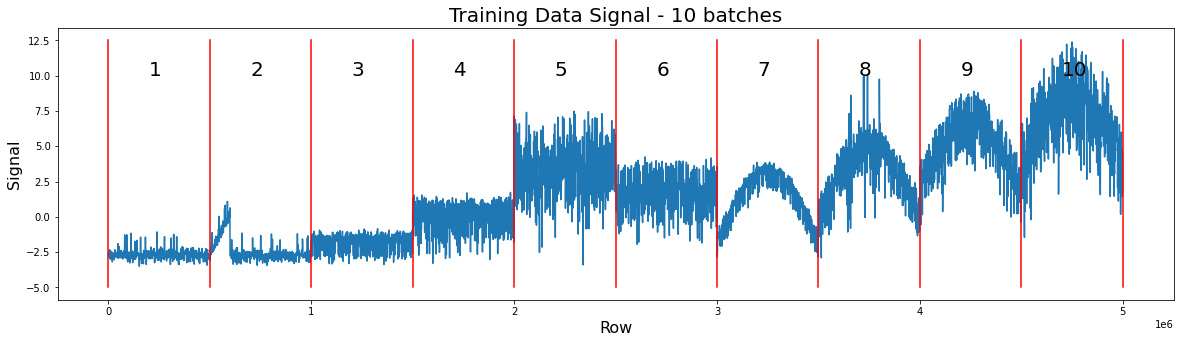

In [6]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,data.shape[0],res),data.signal[0::res])
#plt.plot(range(0,data.shape[0],res),data.open_channels[0::res])

for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

In the batches of 2, 7, 8, 9, and 10, drift was added. It is a signal bias which cause that the signal data change over time in unforeseen ways. The prediction is less accurate as time passes in this condition. So, we need to remove drif data. 

### Remove the slant drift data

In this section, we received help from Chris Deotte's notebook. You can find the details from [here](<https://www.kaggle.com/cdeotte/one-feature-model-0-930>). Chris's calculation says that drift is  

\begin{equation}
    \text{drift data} = 3\times\frac{\text{signal data} - 50}{10}
\end{equation}

We will remove the slant drift data from signal data in batch 2.

In [7]:
#Crete a new clean data as copy of the data

clean_data = data.copy()

#Clean drift data in the batch 2 

a = 500000; b = 600000
clean_data.loc[data.index[a:b],'signal'] = clean_data.signal[a:b].values - 3*(clean_data.time.values[a:b] - 50)/10.

### Remove the parabolic drift data

We removed the slant drift for the batch 2. However, we need to remove the drift in the batches of 7, 8, 9, and 10. They have parabolic drift. We will assume it as a **sine** function. Then, we will try to remove it from the data. 

In this section, we received help from Eunho Lee's notebook. You can find the details from
[here](<https://www.kaggle.com/eunholee/remove-drift-using-a-sine-function>)

### Sine function

Firstly, let us define the sine function as 

\begin{equation}
    y = A \sin(\omega x + \phi) + \delta
\end{equation}  
where $\omega$ is the frequency, $x$ is avaliable **time** data, $\phi$ represents the phase shift, $\delta$ denotes an addition noise, and $A$ is amplitude. We want clean the signal data. $y$ represents the signal data. 

Let us make clear the equation. If we simplify the expression of $A \sin(\omega x + \phi)$,

\begin{equation}
    A \sin(\omega x + \phi) = A \sin(\omega x) cos(\phi) + A \cos(\omega x) sin(\phi)
\end{equation} is obtained. Now, $y$ can be expressed as 

\begin{equation}
    y = A \sin(\omega x) cos(\phi) + A \cos(\omega x) sin(\phi) + \delta
\end{equation}


We can express it as a linear system: 


\begin{equation}
  \begin{bmatrix}
    sin(\omega x_{1}) & cos(\omega x_{1}) & 1 \\ 
    \vdots & \vdots & \vdots \\ 
    sin(\omega x_{n}) & cos(\omega x_{n}) & 1
  \end{bmatrix}
  %
  \begin{bmatrix}
    Acos(\phi) \\
    Asin(\phi) \\
    \delta 
  \end{bmatrix}
  =%
  \begin{bmatrix}
    y_{1} \\
    \vdots \\
    y_{n} \\
  \end{bmatrix}
  %
\end{equation}

where $n$ is 500000 because we work on the $\sin$ function for a batch which has 500000 **time** data points. 

Let us define the matrix as $M$ and the vector as $\theta$. If we simplify the linear system, $y$ can be stated as

\begin{equation}
    M\theta = y
\end{equation} 

Now, we can find the parameters of $A$ and $\phi$ based on $\theta$. 



\begin{align}
    \theta &= (\theta_{1}, \theta_{2}, \theta_{3})\\
    \theta_{1} &= Acos(\phi)\\
    \theta_{2} &= Asin(\phi)\\
    \theta_{3} &= \delta
\end{align}

\begin{align}
    \theta_{1}^2 + \theta_{2}^2 &= A^{2}{cos^{2}(\phi)} + A^{2}{sin^{2}(\phi)}\\
                                &= A^{2}
\end{align}


Then, we can find $A$ and $\phi$, easily.

\begin{align}
    A^{2} &= \theta_{1}^2 + \theta_{2}^2\\
    A &= \sqrt{\theta_{1}^2 + \theta_{2}^2} 
\end{align} 

Now, let us find $\phi$: 

\begin{align}
    \frac{\theta_{2}}{\theta_{1}} &= \frac{Asin(\phi)}{Acos(\phi)}\\
                                 &= \tan(\phi)\\
    \phi &= \tan^{-1}(\frac{\theta_{2}}{\theta_{1}})
\end{align} 

Now, we will try to find optimal $A$ and $\phi$ values for batches of 7,8,9, and 10. Then, we will use these optimal values on the $sine$ function in order to construct the parabolic drift function. 

Firstly, let us define $sine$ function in Python.  

In [8]:
def sin(x, A, phi, delta):
    frequency = 0.01
    omega = 2 * np.pi * frequency
    return A * np.sin(omega * x + phi) + delta

Then, we fit the parabolic drift function to get optimal $A$ and $\phi$ values. 

In [9]:
import math
def parabolic_drift_fit(data):
    x = data['time']
    y = data['signal']

    frequency = 0.01
    omega = 2 * np.pi * frequency
    
    #construct matrix M for every data point t in the time data x
    M = np.array([[np.sin(omega * time_point), np.cos(omega * time_point), 1] for time_point in x])
    
    #construct the signal data y
    y = np.array(y).reshape(len(y), 1)

    #linalg.lstsq function solves the equation a x = b by computing a vector x 
    #that minimizes the squared Euclidean 2-norm
    (theta, _, _, _) = np.linalg.lstsq(M, y)
    
    #find A, phi, and delta parameters
    A = np.sqrt(theta[0,0]**2 + theta[1,0]**2)
    phi = math.atan2(theta[1,0], theta[0,0])
    delta = theta[2,0]

    optimal_parabol_drift = [A, phi, delta]
    
    
    return optimal_parabol_drift

In [10]:
#find optimal parameter values for batch 7
a = 500000*6; b = 500000*7
print(parabolic_drift_fit(data.iloc[a:b]))

#find optimal parameter values for batch 8
a = 500000*7; b = 500000*8
print(parabolic_drift_fit(data.iloc[a:b]))

#find optimal parameter values for batch 9
a = 500000*8; b = 500000*9
print(parabolic_drift_fit(data.iloc[a:b]))

#find optimal parameter values for batch 10
a = 500000*9; b = 500000*10
print(parabolic_drift_fit(data.iloc[a:b]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[4.995587084804994, 0.0005740930714585794, -1.8011184167402234]
[5.070119238472453, 3.1382659776739756, -0.15248293248974062]
[4.962839159679722, 0.0005359057886203599, 1.682621252085318]
[5.074016308177288, 3.1360194015343916, 3.2638369771638014]


So, optimal value of the amplitude, $A$, is $5$. We can say optimal values for the phase shift, $\phi$, are $0$ and $\pi$ for batches of 7,9 and batches of 8,10, respectively. More clearly,

\begin{align}
    A_{optimal} &= 5 \\
    \phi_{optimal} &= 
    \begin{cases}
     0, & \text{if batches of 7 and 9}\\
    \pi, & \text{if batches 8 and 10}
    \end{cases}
\end{align}

However, we will use the result values of the function of `parabolic_drift_fit` for the batches of 7,8,9,10. 


In [12]:
#define parabolic drift function for remove
def remove_parabolic_drift(x, A, opt_phi):
    frequency = 0.01
    omega = 2 * np.pi * frequency
    y = A * np.sin(omega * x + opt_phi)
    return y

In [13]:
#Clean drift data in the batch 7
a = 500000*6; b = 500000*7
clean_data.loc[data.index[a:b],'signal'] = data.signal.values[a:b] - remove_parabolic_drift(data.time[a:b].values, 
                                                                                            4.99, 0)

#Clean drift data in the batch 8
a = 500000*7; b = 500000*8
clean_data.loc[data.index[a:b],'signal'] = data.signal.values[a:b] - remove_parabolic_drift(data.time[a:b].values, 
                                                                                            5.07, 3.138)

#Clean drift data in the batch 9
a = 500000*8; b = 500000*9
clean_data.loc[data.index[a:b],'signal'] = data.signal.values[a:b] - remove_parabolic_drift(data.time[a:b].values, 
                                                                                            4.96, 0)

#Clean drift data in the batch 10
a = 500000*9; b = 500000*10
clean_data.loc[data.index[a:b],'signal'] = data.signal.values[a:b] - remove_parabolic_drift(data.time[a:b].values, 
                                                                                            5.07, 3.136)



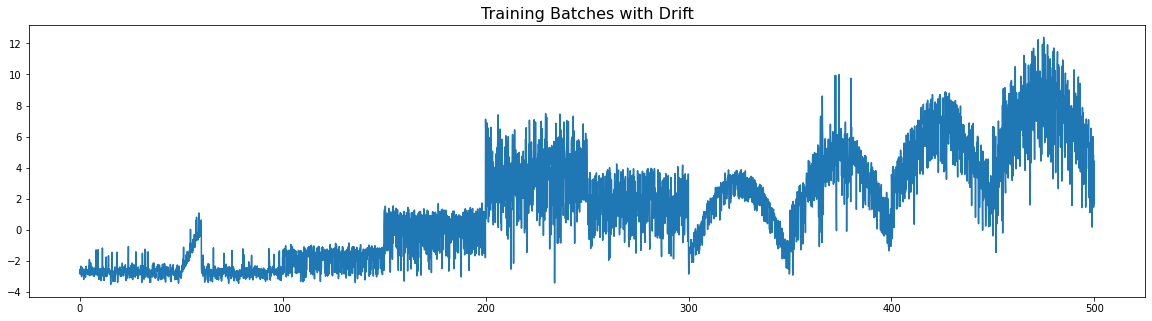

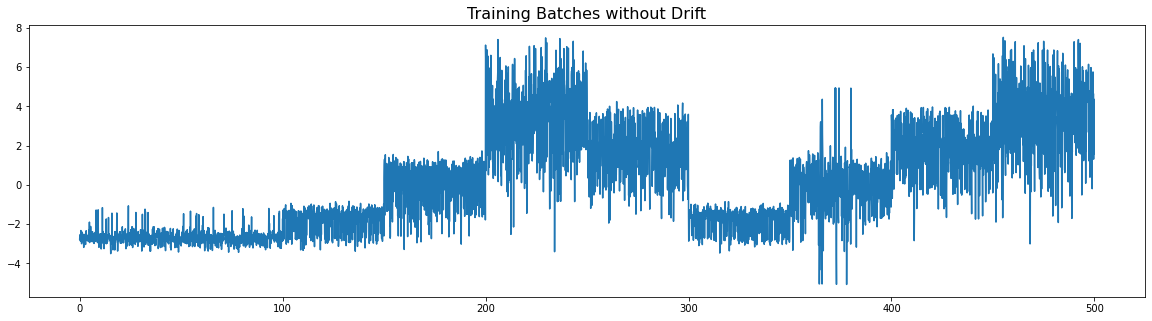

In [14]:
plt.figure(figsize=(20,5))
plt.plot(data.time[::1000],data.signal[::1000])
plt.title('Training Batches with Drift',size=16)


plt.figure(figsize=(20,5))
plt.plot(clean_data.time[::1000],clean_data.signal[::1000])
plt.title('Training Batches without Drift',size=16)
plt.show()

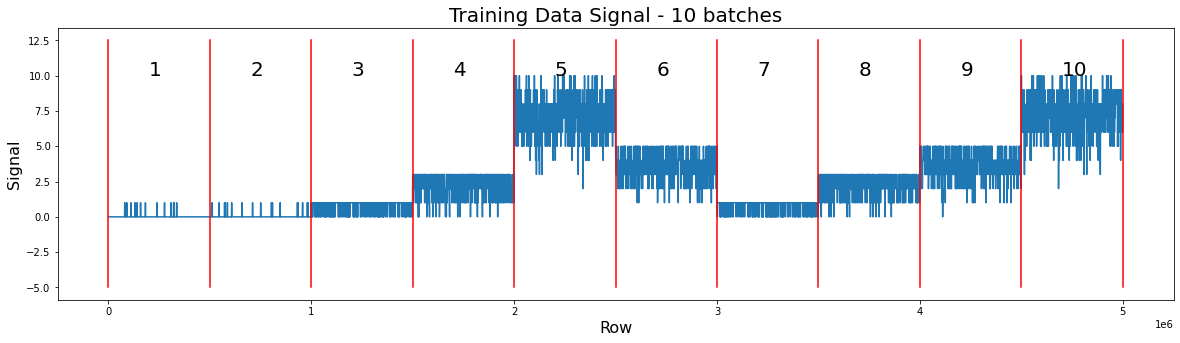

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,5)); res = 1000
#plt.plot(range(0,data.shape[0],res),data.signal[0::res])
plt.plot(range(0,data.shape[0],res),data.open_channels[0::res])

for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

We will try feature scaling at each subset but will apply different scaling at these subsets. There are different numbers of ion channels at each subset. So, we will arrange the signal data in accordance with the numbers of ion channels at each subset. 

### Determine the shape of target set 

Now, let us view the numbers of ion channels in each subset. 

In [17]:
from collections import Counter

part_number = int(data.shape[0]/500000)
ion_channels_number_max = []
ion_channels_number_min = []


for sub_index in range(part_number):
    sub_target_set = subsets[sub_index].iloc[:,-1]
    ion_channels_number_max.append(max(Counter(sub_target_set).keys()))
    ion_channels_number_min.append(min(Counter(sub_target_set).keys()))

Maximum numbers of ion channels at each subset: 

In [18]:
ion_channels_number_max

[1, 1, 1, 3, 10, 5, 1, 3, 5, 10]

Minimum numbers of ion channels at each subset: 

In [19]:
ion_channels_number_min

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

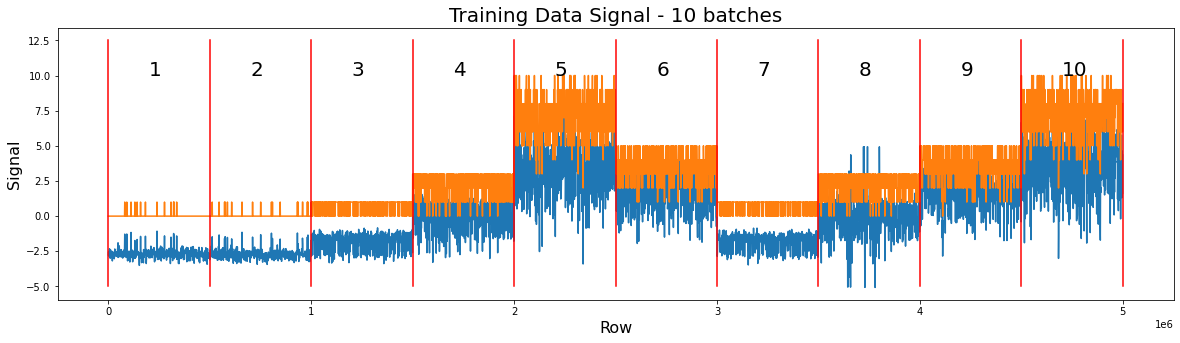

In [20]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,clean_data.shape[0],res),clean_data.signal[0::res])
plt.plot(range(0,data.shape[0],res),data.open_channels[0::res])

for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

In [21]:
clean_subsets = []
#eval_subsets = []

part_number = int(clean_data.shape[0]/500000)
#eval_part_number = int(eval_data.shape[0]/500000)

for part in range(1, part_number+1):
    clean_subsets.append(part)
    clean_subsets[part-1] = clean_data.iloc[((part-1)*500000):part*500000,:]

We will not use variance values but viewing them may be useful for construct and fit the model. 

In [22]:
print("variance of batch 1 : ", clean_subsets[0].signal.var())
print("variance of batch 2 : ", clean_subsets[1].signal.var())
print("\n")
print("variance of batch 3 : ", clean_subsets[2].signal.var())
print("variance of batch 7 : ", clean_subsets[6].signal.var())
print("\n")
print("variance of batch 4 : ", clean_subsets[3].signal.var())
print("variance of batch 8 : ", clean_subsets[7].signal.var())
print("\n")
print("variance of batch 5 : ", clean_subsets[4].signal.var())
print("variance of batch 10 : ", clean_subsets[9].signal.var())
print("\n")
print("variance of batch 6 : ", clean_subsets[5].signal.var())
print("variance of batch 9 : ", clean_subsets[8].signal.var())
print("\n")

variance of batch 1 :  0.10865618352612058
variance of batch 2 :  0.11968473911061112


variance of batch 3 :  0.34853523577348844
variance of batch 7 :  0.34362219428757557


variance of batch 4 :  1.005593452303703
variance of batch 8 :  1.3693928217590303


variance of batch 5 :  3.30608792265254
variance of batch 10 :  3.306725993844274


variance of batch 6 :  1.6349653480896824
variance of batch 9 :  1.6489869450926633




## Construct the model

Now, we have clean data with removal drift. We will the clean data for the models. The models which we use are different architectures for ach batch because they have different distributions.

We will construct 5 different models. In the models, we will use **Conv1D** and **LSTM** architectures, mostly. However, the number of layers and hiddent units in each layer will be different based on the distribution and the variance.

We will use hidden layers in the batches follow as: 

#### Batches 1 and 2 

LSTM(1)

#### Batches 3 and 7 

LSTM(8)

#### Batches 4 and 8 

Conv1D(16) - LSTM(16)

#### Batches 6 and 9

Conv1D(24) - LSTM(24)

#### Batches 5 and 10

Conv1D(24) - LSTM(24) - LSTM(24) - LSTM(24)

In [33]:
from collections import Counter
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, Dropout, Flatten, BatchNormalization, Conv1D, Activation, RepeatVector, TimeDistributed
from keras.models import Sequential, Input, Model
from keras.regularizers import l1, l2, l1_l2


class lstm_model:
    
    def __init__(self, part1, part2):
        self.part1 = part1
        self.part2 = part2
        #self.eval_subset_data = eval_subset_data
        
    def create_features(self):
        part1 = self.part1
        part2 = self.part2
        
        features = np.concatenate([clean_subsets[part1].signal, clean_subsets[part2].signal])
        features = np.expand_dims(features, axis = 1)
        
        return features
        
    def create_target(self):
        part1 = self.part1
        part2 = self.part2
        #target_set = self.subset_data.iloc[:,-1]
        
        target = np.concatenate([clean_subsets[part1].open_channels, clean_subsets[part2].open_channels])

        
        #target = np.array(target_set)
        #target = to_categorical(target)
        
        return target
    
    def train_size(self, rate):
    
        all_size = 1000000
        train_end = int(all_size*rate)
        
        return train_end
        
    
    def create_train_features(self, train_rate):
        features = self.create_features()
        train_end = self.train_size(train_rate)
        start = 0
        
        train_features = features[start:train_end]
        train_features = np.expand_dims(train_features, axis = 1)
        
        return train_features
    
    
    def create_test_features(self, train_rate):
        features = self.create_features()
        train_end = self.train_size(train_rate)
        end = features.shape[0]
        
        test_features = features[train_end:end]
        test_features = np.expand_dims(test_features, axis = 1)
        
        return test_features
    
    def create_train_target(self, train_rate):
        target = self.create_target()
        train_end = self.train_size(train_rate)
        start = 0
        
        train_target = target[start:train_end]
        train_target = to_categorical(train_target)
        
        return train_target
    
    def create_test_target(self, train_rate):
        features = self.create_features()
        target = self.create_target()
        train_end = self.train_size(train_rate)
        end = features.shape[0]
        
        test_target = target[train_end:end]
        test_target = to_categorical(test_target)
        
        return test_target
    
    
    def construct_model_for_batch_1_2(self):
        features = self.create_features()
        index = self.part1
        
        maximum_channel_number = ion_channels_number_max[index]
        
        model  = Sequential()

        #model.add(Conv1D(1, 1, input_shape=(features.shape[1], 1), activation='relu'))
        model.add(LSTM(1, input_shape=(features.shape[1], 1), return_sequences=False, activation='tanh'))
        model.add(Dense(maximum_channel_number+1, activation='sigmoid'))
        
        return model
    
    def construct_model_for_batch_3_7(self):
        features = self.create_features()
        index = self.part1
        
        maximum_channel_number = ion_channels_number_max[index]
        
        model  = Sequential()
        
        #model.add(Conv1D(4, 1, input_shape=(features.shape[1], 1), activation='relu'))
        model.add(LSTM(8, input_shape=(features.shape[1], 1), return_sequences=False, activation='tanh'))
        model.add(Dense(maximum_channel_number+1, activation='sigmoid'))
        
        return model
    
    def construct_model_for_batch_4_8(self):
        features = self.create_features()
        index = self.part1
        
        maximum_channel_number = ion_channels_number_max[index]
        
        model  = Sequential()

        model.add(Conv1D(16, 1, input_shape=(features.shape[1], 1), activation='relu'))
        model.add(LSTM(16, return_sequences=False, activation='tanh'))
        model.add(Dense(maximum_channel_number+1, activation='sigmoid'))
        
        return model
    
    def construct_model_for_batch_6_9(self):
        features = self.create_features()
        index = self.part1
        
        maximum_channel_number = ion_channels_number_max[index]
        
        model  = Sequential()

        model.add(Conv1D(24, 1, input_shape=(features.shape[1], 1), activation='relu'))
        model.add(LSTM(24, return_sequences=False, activation='tanh'))
        model.add(Dense(maximum_channel_number+1, activation='sigmoid'))
        
        return model
    
    def construct_model_for_batch_5_10(self):
        features = self.create_features()
        index = self.part1
        
        maximum_channel_number = ion_channels_number_max[index]
        
        model  = Sequential()

        model.add(Conv1D(24, 1, input_shape=(features.shape[1], 1), activation='relu'))
        
        model.add(LSTM(24, return_sequences=True, activation='tanh'))
        model.add(LSTM(24, return_sequences=True, activation='tanh'))
        model.add(LSTM(24, return_sequences=False, activation='tanh'))

        model.add(Dense(maximum_channel_number+1, activation='sigmoid'))
        
        return model

In [24]:
train_split_rate = 0.85
model1 = lstm_model(part1=0, part2=1)
processed_model1 = model1.construct_model_for_batch_1_2()

train_feature_model1 = model1.create_train_features(train_split_rate)
train_target_model1 = model1.create_train_target(train_split_rate)

test_feature_model1 = model1.create_test_features(train_split_rate)
test_target_model1 = model1.create_test_target(train_split_rate)


processed_model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

rnn = processed_model1.fit(train_feature_model1, train_target_model1, batch_size=1000, epochs=20, 
                           validation_data=(test_feature_model1, test_target_model1))

Train on 850000 samples, validate on 150000 samples
Epoch 1/20
850000/850000 [==============================] - 4s 5us/step - loss: 0.4560 - accuracy: 0.9657 - val_loss: 0.2881 - val_accuracy: 0.9595
Epoch 2/20
850000/850000 [==============================] - 3s 3us/step - loss: 0.2008 - accuracy: 0.9657 - val_loss: 0.1479 - val_accuracy: 0.9595
Epoch 3/20
850000/850000 [==============================] - 3s 3us/step - loss: 0.1063 - accuracy: 0.9710 - val_loss: 0.0847 - val_accuracy: 0.9762
Epoch 4/20
850000/850000 [==============================] - 3s 3us/step - loss: 0.0627 - accuracy: 0.9874 - val_loss: 0.0517 - val_accuracy: 0.9907
Epoch 5/20
850000/850000 [==============================] - 3s 4us/step - loss: 0.0388 - accuracy: 0.9949 - val_loss: 0.0324 - val_accuracy: 0.9954
Epoch 6/20
850000/850000 [==============================] - 3s 3us/step - loss: 0.0251 - accuracy: 0.9969 - val_loss: 0.0215 - val_accuracy: 0.9971
Epoch 7/20
850000/850000 [==============================] - 

Text(0.5, 1.0, 'Accuracy Curves')

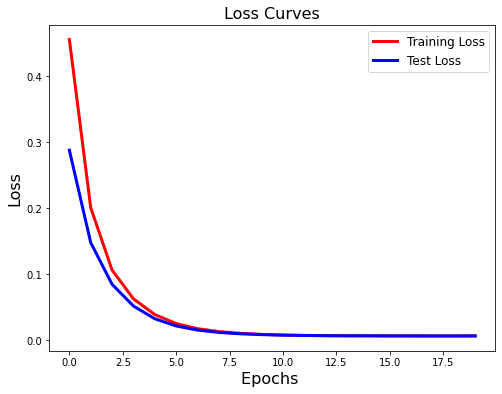

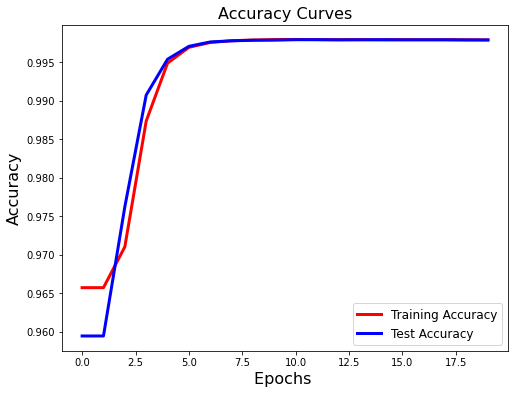

In [25]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
train_loss, = plt.plot(rnn.history['loss'],'r',linewidth=3.0)
test_loss, = plt.plot(rnn.history['val_loss'],'b',linewidth=3.0)
plt.legend([train_loss, test_loss], ['Training Loss', 'Test Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
train_accuracy, = plt.plot(rnn.history['accuracy'],'r',linewidth=3.0)
test_accuracy, = plt.plot(rnn.history['val_accuracy'],'b',linewidth=3.0)
plt.legend([train_accuracy, test_accuracy], ['Training Accuracy', 'Test Accuracy'],fontsize=12)

plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [26]:
#construct the lstm model for batch 3 and 7

train_split_rate = 0.67
model2 = lstm_model(2, 6)
processed_model2 = model2.construct_model_for_batch_3_7()

train_feature_model2 = model2.create_train_features(train_split_rate)
train_target_model2 = model2.create_train_target(train_split_rate)

test_feature_model2 = model2.create_test_features(train_split_rate)
test_target_model2 = model2.create_test_target(train_split_rate)


processed_model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

rnn = processed_model2.fit(train_feature_model2, train_target_model2, batch_size=1000, epochs=25, 
                           validation_data=(test_feature_model2, test_target_model2))

Train on 670000 samples, validate on 330000 samples
Epoch 1/25
670000/670000 [==============================] - 4s 5us/step - loss: 0.4759 - accuracy: 0.7794 - val_loss: 0.2507 - val_accuracy: 0.9498
Epoch 2/25
670000/670000 [==============================] - 3s 5us/step - loss: 0.1369 - accuracy: 0.9872 - val_loss: 0.0731 - val_accuracy: 0.9937
Epoch 3/25
670000/670000 [==============================] - 3s 5us/step - loss: 0.0522 - accuracy: 0.9944 - val_loss: 0.0388 - val_accuracy: 0.9945
Epoch 4/25
670000/670000 [==============================] - 3s 5us/step - loss: 0.0320 - accuracy: 0.9945 - val_loss: 0.0272 - val_accuracy: 0.9945
Epoch 5/25
670000/670000 [==============================] - 3s 5us/step - loss: 0.0242 - accuracy: 0.9946 - val_loss: 0.0220 - val_accuracy: 0.9945
Epoch 6/25
670000/670000 [==============================] - 3s 5us/step - loss: 0.0203 - accuracy: 0.9945 - val_loss: 0.0192 - val_accuracy: 0.9946
Epoch 7/25
670000/670000 [==============================] - 

Text(0.5, 1.0, 'Accuracy Curves')

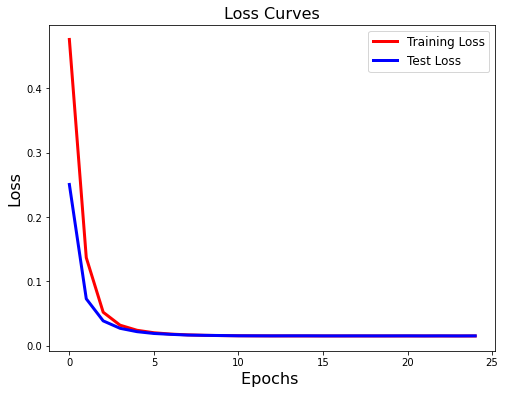

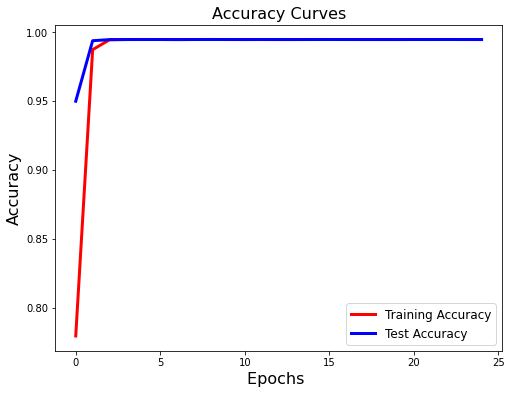

In [27]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
train_loss, = plt.plot(rnn.history['loss'],'r',linewidth=3.0)
test_loss, = plt.plot(rnn.history['val_loss'],'b',linewidth=3.0)
plt.legend([train_loss, test_loss], ['Training Loss', 'Test Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
train_accuracy, = plt.plot(rnn.history['accuracy'],'r',linewidth=3.0)
test_accuracy, = plt.plot(rnn.history['val_accuracy'],'b',linewidth=3.0)
plt.legend([train_accuracy, test_accuracy], ['Training Accuracy', 'Test Accuracy'],fontsize=12)

plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [28]:
#construct the lstm model for batch 4 and 8

train_split_rate = 0.75
model3 = lstm_model(3, 7)
processed_model3 = model3.construct_model_for_batch_4_8()

train_feature_model3 = model3.create_train_features(train_split_rate)
train_target_model3 = model3.create_train_target(train_split_rate)

test_feature_model3 = model3.create_test_features(train_split_rate)
test_target_model3 = model3.create_test_target(train_split_rate)


#opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
processed_model3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])


rnn = processed_model3.fit(train_feature_model3, train_target_model3, batch_size=1000, epochs=40, 
                           validation_data=(test_feature_model3, test_target_model3))

Train on 750000 samples, validate on 250000 samples
Epoch 1/40
750000/750000 [==============================] - 5s 6us/step - loss: 0.5765 - accuracy: 0.7664 - val_loss: 0.2586 - val_accuracy: 0.9246
Epoch 2/40
750000/750000 [==============================] - 4s 5us/step - loss: 0.1687 - accuracy: 0.9440 - val_loss: 0.1244 - val_accuracy: 0.9463
Epoch 3/40
750000/750000 [==============================] - 4s 5us/step - loss: 0.1374 - accuracy: 0.9453 - val_loss: 0.1161 - val_accuracy: 0.9464
Epoch 4/40
750000/750000 [==============================] - 4s 6us/step - loss: 0.1339 - accuracy: 0.9452 - val_loss: 0.1160 - val_accuracy: 0.9454
Epoch 5/40
750000/750000 [==============================] - 4s 6us/step - loss: 0.1323 - accuracy: 0.9448 - val_loss: 0.1158 - val_accuracy: 0.9466
Epoch 6/40
750000/750000 [==============================] - 4s 5us/step - loss: 0.1307 - accuracy: 0.9496 - val_loss: 0.1148 - val_accuracy: 0.9603
Epoch 7/40
750000/750000 [==============================] - 

Text(0.5, 1.0, 'Accuracy Curves')

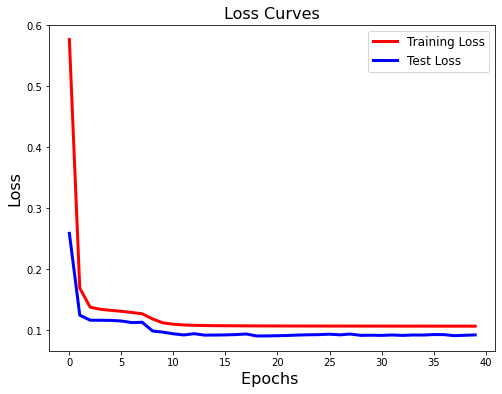

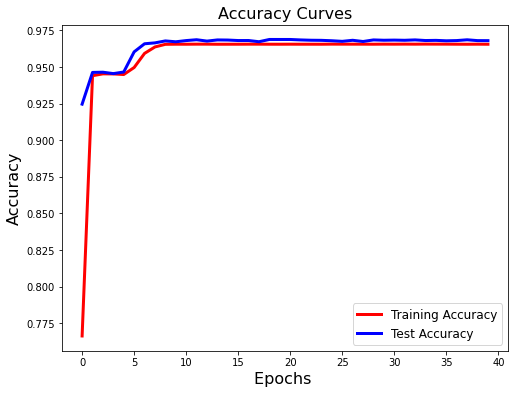

In [29]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
train_loss, = plt.plot(rnn.history['loss'],'r',linewidth=3.0)
test_loss, = plt.plot(rnn.history['val_loss'],'b',linewidth=3.0)
plt.legend([train_loss, test_loss], ['Training Loss', 'Test Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
train_accuracy, = plt.plot(rnn.history['accuracy'],'r',linewidth=3.0)
test_accuracy, = plt.plot(rnn.history['val_accuracy'],'b',linewidth=3.0)
plt.legend([train_accuracy, test_accuracy], ['Training Accuracy', 'Test Accuracy'],fontsize=12)

plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [30]:
#construct the lstm model for batch 6 and 9

train_split_rate = 0.67
model4 = lstm_model(5, 8)
processed_model4 = model4.construct_model_for_batch_6_9()

train_feature_model4 = model4.create_train_features(train_split_rate)
train_target_model4 = model4.create_train_target(train_split_rate)

test_feature_model4 = model4.create_test_features(train_split_rate)
test_target_model4 = model4.create_test_target(train_split_rate)


processed_model4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

rnn = processed_model4.fit(train_feature_model4, train_target_model4, batch_size=1000, epochs=25, 
                           validation_data=(test_feature_model4, test_target_model4))

Train on 670000 samples, validate on 330000 samples
Epoch 1/25
670000/670000 [==============================] - 5s 8us/step - loss: 0.7339 - accuracy: 0.6523 - val_loss: 0.2750 - val_accuracy: 0.7715
Epoch 2/25
670000/670000 [==============================] - 5s 7us/step - loss: 0.2441 - accuracy: 0.7703 - val_loss: 0.2263 - val_accuracy: 0.7716
Epoch 3/25
670000/670000 [==============================] - 5s 7us/step - loss: 0.2231 - accuracy: 0.7750 - val_loss: 0.2168 - val_accuracy: 0.7916
Epoch 4/25
670000/670000 [==============================] - 5s 7us/step - loss: 0.1797 - accuracy: 0.9257 - val_loss: 0.0883 - val_accuracy: 0.9707
Epoch 5/25
670000/670000 [==============================] - 5s 7us/step - loss: 0.0861 - accuracy: 0.9697 - val_loss: 0.0816 - val_accuracy: 0.9706
Epoch 6/25
670000/670000 [==============================] - 5s 7us/step - loss: 0.0824 - accuracy: 0.9697 - val_loss: 0.0784 - val_accuracy: 0.9710
Epoch 7/25
670000/670000 [==============================] - 

Text(0.5, 1.0, 'Accuracy Curves')

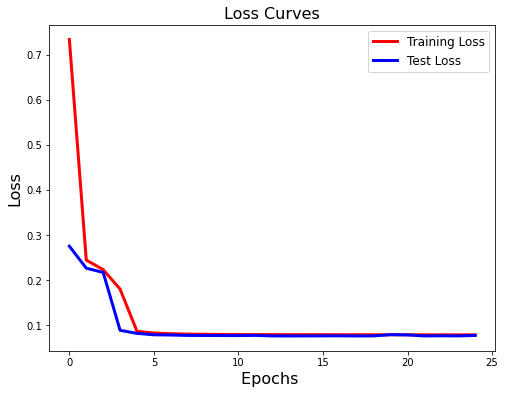

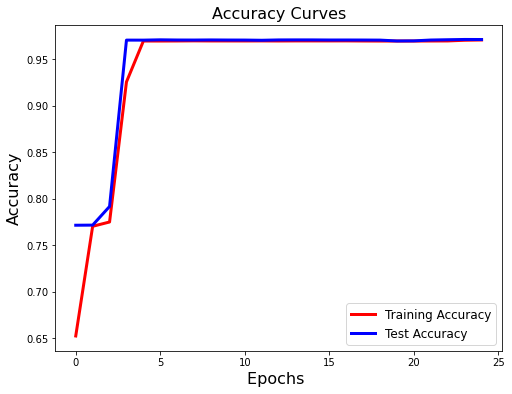

In [31]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
train_loss, = plt.plot(rnn.history['loss'],'r',linewidth=3.0)
test_loss, = plt.plot(rnn.history['val_loss'],'b',linewidth=3.0)
plt.legend([train_loss, test_loss], ['Training Loss', 'Test Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
train_accuracy, = plt.plot(rnn.history['accuracy'],'r',linewidth=3.0)
test_accuracy, = plt.plot(rnn.history['val_accuracy'],'b',linewidth=3.0)
plt.legend([train_accuracy, test_accuracy], ['Training Accuracy', 'Test Accuracy'],fontsize=12)

plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [34]:
#construct the lstm model for batch 5 and 10
import keras
import numpy as np

train_split_rate = 0.75
model5 = lstm_model(4, 9)
processed_model5 = model5.construct_model_for_batch_5_10()

train_feature_model5 = model5.create_train_features(train_split_rate)
train_target_model5 = model5.create_train_target(train_split_rate)

test_feature_model5 = model5.create_test_features(train_split_rate)
test_target_model5 = model5.create_test_target(train_split_rate)


#opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
processed_model5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

rnn = processed_model5.fit(train_feature_model5, train_target_model5, batch_size=1000, epochs=30,
                           validation_data=(test_feature_model5, test_target_model5))

Train on 750000 samples, validate on 250000 samples
Epoch 1/30
750000/750000 [==============================] - 11s 15us/step - loss: 1.2485 - accuracy: 0.4733 - val_loss: 0.6257 - val_accuracy: 0.7065
Epoch 2/30
750000/750000 [==============================] - 10s 14us/step - loss: 0.5030 - accuracy: 0.8086 - val_loss: 0.4380 - val_accuracy: 0.8394
Epoch 3/30
750000/750000 [==============================] - 10s 13us/step - loss: 0.4054 - accuracy: 0.8420 - val_loss: 0.3841 - val_accuracy: 0.8416
Epoch 4/30
750000/750000 [==============================] - 10s 14us/step - loss: 0.3603 - accuracy: 0.8427 - val_loss: 0.3505 - val_accuracy: 0.8497
Epoch 5/30
750000/750000 [==============================] - 10s 13us/step - loss: 0.3380 - accuracy: 0.8706 - val_loss: 0.3331 - val_accuracy: 0.8728
Epoch 6/30
750000/750000 [==============================] - 10s 13us/step - loss: 0.3242 - accuracy: 0.8741 - val_loss: 0.3261 - val_accuracy: 0.8721
Epoch 7/30
750000/750000 [======================

Text(0.5, 1.0, 'Accuracy Curves')

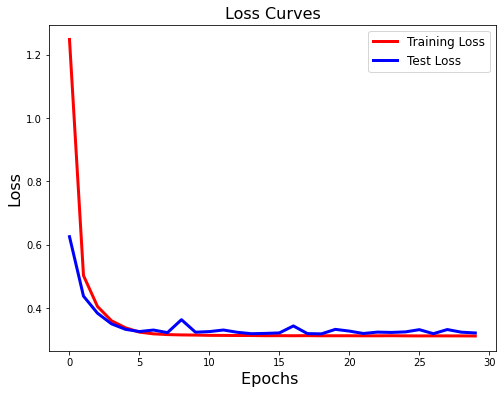

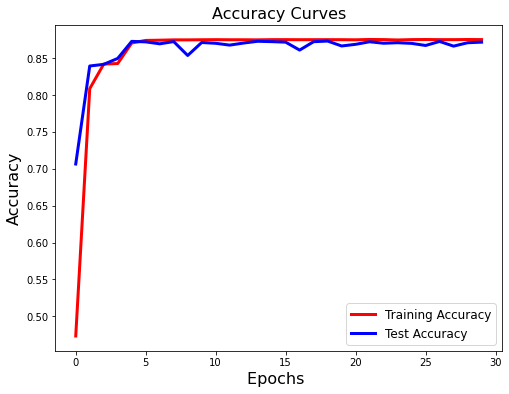

In [35]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
train_loss, = plt.plot(rnn.history['loss'],'r',linewidth=3.0)
test_loss, = plt.plot(rnn.history['val_loss'],'b',linewidth=3.0)
plt.legend([train_loss, test_loss], ['Training Loss', 'Test Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
train_accuracy, = plt.plot(rnn.history['accuracy'],'r',linewidth=3.0)
test_accuracy, = plt.plot(rnn.history['val_accuracy'],'b',linewidth=3.0)
plt.legend([train_accuracy, test_accuracy], ['Training Accuracy', 'Test Accuracy'],fontsize=12)

plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Prepare test data for predict 

Firstly, let us view the distribution of test data. Then, we will determine that we will use which train model for which part of test. 

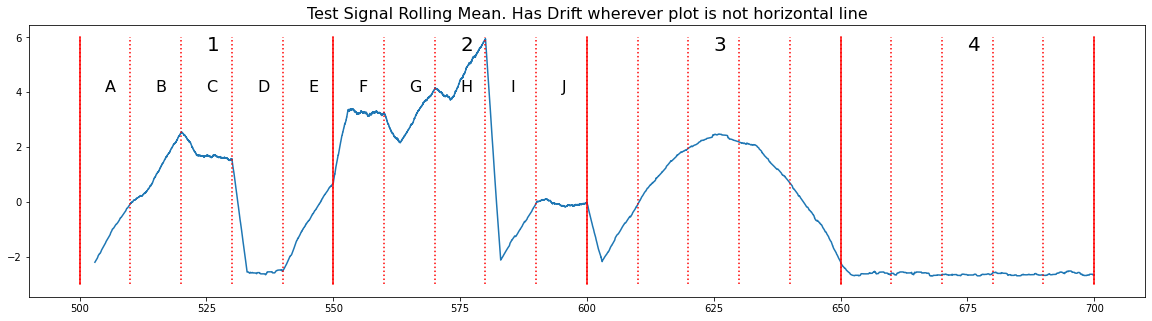

In [36]:
plt.figure(figsize=(20,5))
let = ['A','B','C','D','E','F','G','H','I','J']

r = eval_data.signal.rolling(30000).mean()
plt.plot(eval_data.time.values,r)

for i in range(21): plt.plot([500+i*10,500+i*10],[-3,6],'r:')
for i in range(5): plt.plot([500+i*50,500+i*50],[-3,6],'r')
for k in range(4): plt.text(525+k*50,5.5,str(k+1),size=20)
for k in range(10): plt.text(505+k*10,4,let[k],size=16)
plt.title('Test Signal Rolling Mean. Has Drift wherever plot is not horizontal line',size=16)
plt.show()

### Removal drift test data 

So, we will remove the parabolic drift data in the part of 3. There are the slant drift data in other parts. We will apply the function that we used as before for removing the slant drift data. 

In [37]:
# removing drift for the subparts of A, B, and E in the batch 1 

#removing drift in the A
start=500
a = 0; b = 100000
eval_data.loc[eval_data.index[a:b],'signal'] = eval_data.signal.values[a:b] - 3*(eval_data.time.values[a:b]-start)/10.

#removing drift in the B
start=510
a = 100000; b = 200000
eval_data.loc[eval_data.index[a:b],'signal'] = eval_data.signal.values[a:b] - 3*(eval_data.time.values[a:b]-start)/10.

#removing drift in the E
start=540
a = 400000; b = 500000
eval_data.loc[eval_data.index[a:b],'signal'] = eval_data.signal.values[a:b] - 3*(eval_data.time.values[a:b]-start)/10.

In [38]:
# removing drift for the subparts of G, H, and I in the batch 2 

#removing drift in the G
start=560
a = 600000; b = 700000
eval_data.loc[eval_data.index[a:b],'signal'] = eval_data.signal.values[a:b] - 3*(eval_data.time.values[a:b]-start)/10.

#removing drift in the H
start=570
a = 700000; b = 800000
eval_data.loc[eval_data.index[a:b],'signal'] = eval_data.signal.values[a:b] - 3*(eval_data.time.values[a:b]-start)/10.

#removing drift in the I
start=580
a = 800000; b = 900000
eval_data.loc[eval_data.index[a:b],'signal'] = eval_data.signal.values[a:b] - 3*(eval_data.time.values[a:b]-start)/10.

In [39]:
a = 1000000; b = 1500000
print(parabolic_drift_fit(eval_data.iloc[a:b]))

[4.999813566012916, -0.0020396843852438207, -2.599153522167454]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [40]:
#removing drift for the data in the batch 3
a = 1000000; b = 1500000
eval_data.loc[eval_data.index[a:b],'signal'] = eval_data.signal.values[a:b] - remove_parabolic_drift(eval_data.time[a:b].values, 4.99, 0)

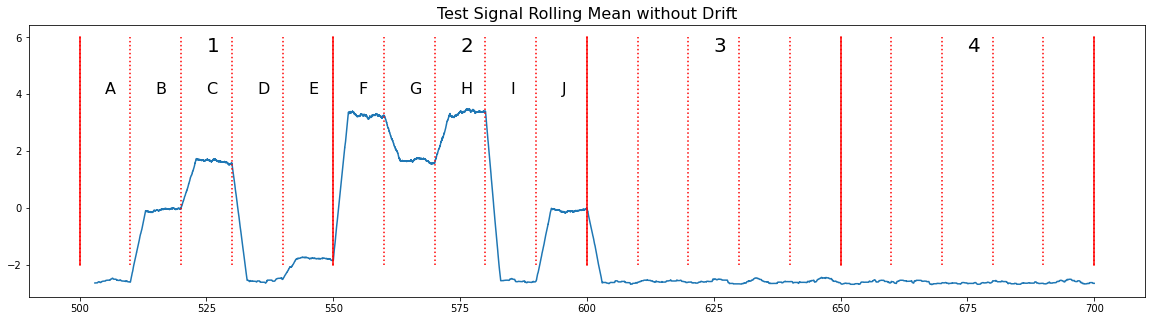

In [41]:

plt.figure(figsize=(20,5))
r = eval_data.signal.rolling(30000).mean()
plt.plot(eval_data.time.values,r)
for i in range(21): plt.plot([500+i*10,500+i*10],[-2,6],'r:')
for i in range(5): plt.plot([500+i*50,500+i*50],[-2,6],'r')
for k in range(4): plt.text(525+k*50,5.5,str(k+1),size=20)
for k in range(10): plt.text(505+k*10,4,let[k],size=16)
plt.title('Test Signal Rolling Mean without Drift',size=16)
plt.show()

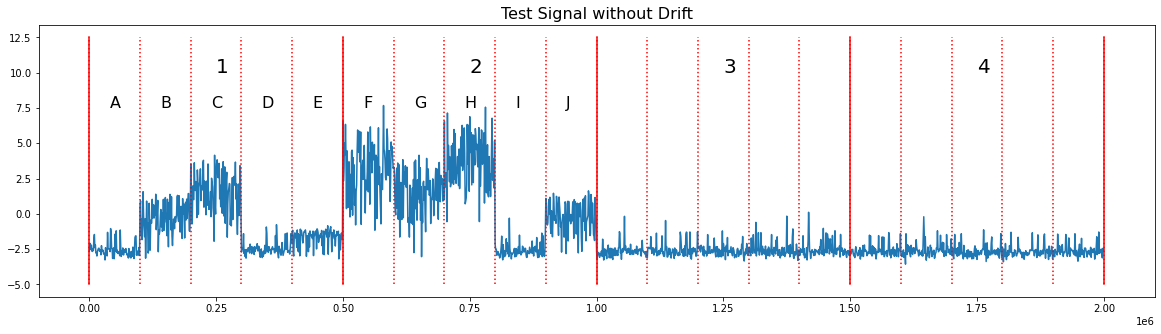

In [42]:
plt.figure(figsize=(20,5))
res = 1000
plt.plot(range(0,eval_data.shape[0],res),eval_data.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Signal without Drift',size=16)
plt.show()


Again, let us view the train data without parabolic and slant drift. 

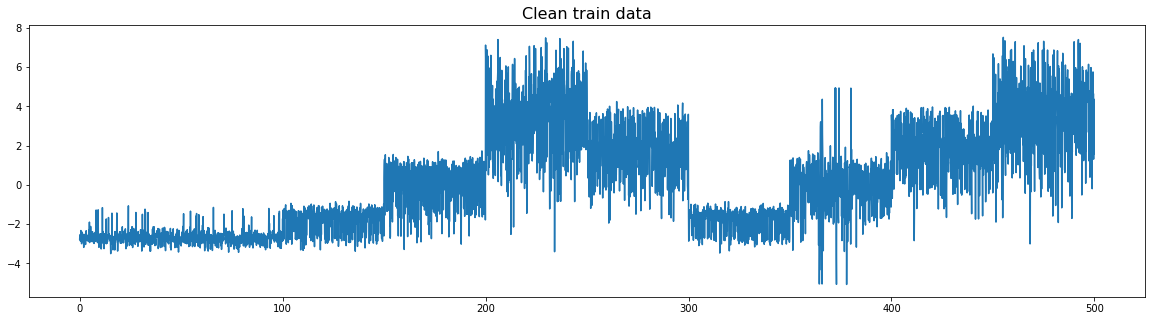

In [45]:
plt.figure(figsize=(20,5))
plt.plot(clean_data.time[::1000],clean_data.signal[::1000])
plt.title('Clean train data',size=16)
plt.show()

We will run different five models different part in the test data which has not drift data. As we see plot above;

* we will use the model which is constructed batch 1 and 2 for the test data in the subparts of A, D, I, parts of 3 and 4
* we will use the model which is constructed batch 3 and 7 for the test data in the subpart of E
* we will use the model which is constructed batch 4 and 8 for the test data in the subparts of B and J
* we will use the model which is constructed batch 6 and 9 for the test data in the subparts of C and G
* we will use the model which is constructed batch 5 and 10 for the test data in the subparts of F and H


## Prediction and Submission

In [46]:
submission = pd.read_csv('/kaggle/input/liverpool-ion-switching/sample_submission.csv')

In [47]:
#prediction of the subparts of A,D,I, the parts of 3 and 4

eval_A = eval_data.signal.values[0:100000].reshape(-1,1)
eval_A = np.expand_dims(eval_A, axis = 2)

eval_D = eval_data.signal.values[300000:400000].reshape(-1,1)
eval_D = np.expand_dims(eval_D, axis = 2)

eval_I = eval_data.signal.values[800000:900000].reshape(-1,1)
eval_I = np.expand_dims(eval_I, axis = 2)

eval_3 = eval_data.signal.values[1000000:1500000].reshape(-1,1)
eval_3 = np.expand_dims(eval_3, axis = 2)

eval_4 = eval_data.signal.values[1500000:2000000].reshape(-1,1)
eval_4 = np.expand_dims(eval_4, axis = 2)


pred_A = processed_model1.predict_classes(eval_A)
pred_D = processed_model1.predict_classes(eval_D)
pred_I = processed_model1.predict_classes(eval_I)
pred_3 = processed_model1.predict_classes(eval_3)
pred_4 = processed_model1.predict_classes(eval_4)

#assign the predictions to the submission data
submission.iloc[0:100000, 1] = pred_A
submission.iloc[300000:400000, 1] = pred_D
submission.iloc[800000:900000, 1] = pred_I
submission.iloc[1000000:1500000, 1] = pred_3
submission.iloc[1500000:2000000, 1] = pred_4

In [48]:
#prediction of the subpart of E

eval_E = eval_data.signal.values[400000:500000].reshape(-1,1)
eval_E = np.expand_dims(eval_E, axis = 2)

pred_E = processed_model2.predict_classes(eval_E)

#assign the prediction to the submission data
submission.iloc[400000:500000, 1] = pred_E

In [49]:
#prediction of the subparts of B and J

eval_B = eval_data.signal.values[100000:200000].reshape(-1,1)
eval_B = np.expand_dims(eval_B, axis = 2)

eval_J = eval_data.signal.values[900000:1000000].reshape(-1,1)
eval_J = np.expand_dims(eval_J, axis = 2)

pred_B = processed_model3.predict_classes(eval_B)
pred_J = processed_model3.predict_classes(eval_J)

#assign the predictions to the submission data
submission.iloc[100000:200000, 1] = pred_B
submission.iloc[900000:1000000, 1] = pred_J

In [50]:
#prediction of the subparts of C and G

eval_C = eval_data.signal.values[200000:300000].reshape(-1,1)
eval_C = np.expand_dims(eval_C, axis = 2)

eval_G = eval_data.signal.values[600000:700000].reshape(-1,1)
eval_G = np.expand_dims(eval_G, axis = 2)

pred_C = processed_model4.predict_classes(eval_C)
pred_G = processed_model4.predict_classes(eval_G)

#assign the predictions to the submission data
submission.iloc[200000:300000, 1] = pred_C
submission.iloc[600000:700000, 1] = pred_G

In [51]:
#prediction of the subparts of F and H


eval_F = eval_data.signal.values[500000:600000].reshape(-1,1)
eval_F = np.expand_dims(eval_F, axis = 2)

eval_H = eval_data.signal.values[700000:800000].reshape(-1,1)
eval_H = np.expand_dims(eval_H, axis = 2)

pred_F = processed_model5.predict_classes(eval_F)
pred_H = processed_model5.predict_classes(eval_H)

#assign the predictions to the submission data
submission.iloc[500000:600000, 1] = pred_F
submission.iloc[700000:800000, 1] = pred_H

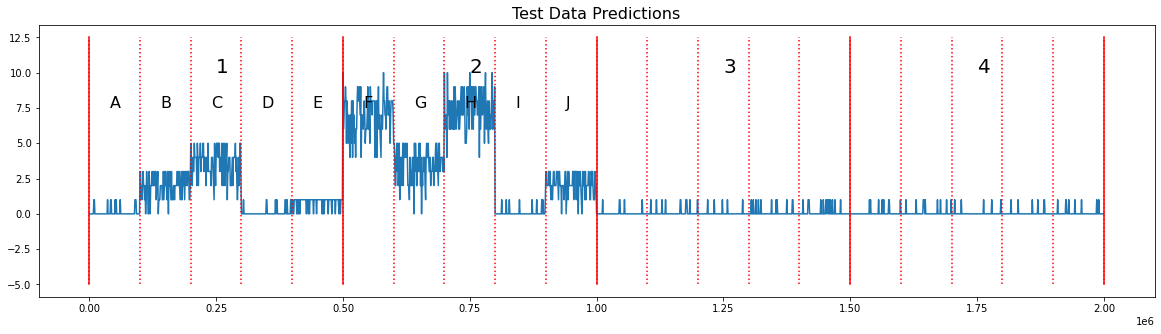

In [52]:
plt.figure(figsize=(20,5))
res = 1000
plt.plot(range(0,eval_data.shape[0],res),submission.open_channels[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
plt.title('Test Data Predictions',size=16)
plt.show()

In [53]:
submission.to_csv('ion_switch_submission.csv', index = False, float_format='%.4f')

## Conclusion

The max f1 score of this submission is around 0.930. Especially, we can develop fifth model which is constructed for the batches of 5 and 10. LSTM Autoencoder or Conv2D may be useful architecture. Sure, if we use the architecture of Conv2D, we must change the shape of data. 